In [1]:
import os
import sys
sys.path.append('../..')
import numpy as np
import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel
from deepbayesHF.analyzers import FGSM
from deepbayesHF.analyzers import eps_LRP
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import random
import matplotlib.pyplot as plt
from collections import namedtuple

from joblib import Parallel, delayed
import subprocess
from statistics import mode
import json
import imageio

In [2]:
X_train, y_train = [], []

widths = []
heights = []
train_dir = '/home/rhiba/bayesian-ores/training_data/gtsrb/Final_Training/Images/'
for class_dir in os.listdir(train_dir):
    classid = int(class_dir)
    full_path = os.path.join(train_dir,class_dir)
    images = [x for x in os.listdir(full_path) if x.endswith('.ppm')]
    for i in images:
        actual_image = imageio.imread(os.path.join(full_path,i))
        widths.append(len(actual_image[0]))
        heights.append(len(actual_image))
        X_train.append(actual_image)
        y_train.append(classid)

In [3]:
print('Min and max widths:',min(widths),max(widths))
print('Min and max heights:',min(heights),max(heights))
rescale_size = (30,30)
print('Rescaling to:',rescale_size)

if not rescale_size == X_train[0].shape:
    X_train = np.array(list(map(lambda x:cv2.resize(x,rescale_size,interpolation=cv2.INTER_CUBIC),X_train)))
X_train = X_train/255.

Min and max widths: 25 243
Min and max heights: 25 225
Rescaling to: (30, 30)


In [4]:
zipped = list(zip(X_train,y_train))
#random.shuffle(zipped)
X_train = list(list(zip(*zipped))[0])
y_train = list(list(zip(*zipped))[1])
split_point = int(0.8*len(X_train))
X_test = X_train[split_point:]
X_train = X_train[:split_point]
y_test = y_train[split_point:]
y_train = y_train[:split_point]

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [6]:
# FLATTEN INPUT FOR FC NET
#X_train = X_train.astype("float32").reshape(-1, rescale_size[0]*rescale_size[1])
#X_test = X_test.astype("float32").reshape(-1, rescale_size[0]*rescale_size[1])

(30, 30, 3)
42


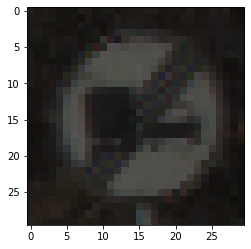

In [7]:
print(X_train[0].shape)
plt.imshow(X_train[0])
print(np.max(y_train))

In [132]:
model_name = f'GTSRB_{rescale_size[0]}x{rescale_size[1]}im_ig'

opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()

inputs = Input(shape=X_train[0].shape)
tmp = Conv2D(4,3,padding='same',activation='relu')(inputs)
tmp = MaxPooling2D()(tmp)
tmp = Conv2D(8,3,padding='same',activation='relu')(tmp)
tmp = MaxPooling2D()(tmp)
tmp = Flatten()(tmp)
tmp = Dense(128,activation='relu')(tmp)
predictions = Dense(43,activation='softmax')(tmp)
model = Model(inputs=inputs,outputs=predictions)

'''
model = Sequential()
model.add(Input(shape=X_train[0].shape))
model.add(Conv2D(4,3,padding='same',activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(8,3,padding='same',activation='relu'))
#model.add(MaxPooling2D())
#model.add(Conv2D(64,3,padding='same',activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(43,activation='softmax'))
'''

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')
bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(3, 3, 3, 4) 0.2721655269759087
(3, 3, 4, 8) 0.23570226039551584
(392, 128) 0.07142857142857142
(128, 43) 0.125
deepbayes: Using implicit prior
(3, 3, 3, 4) 0.2721655269759087
(3, 3, 4, 8) 0.23570226039551584
(392, 128) 0.07142857142857142
(128, 43) 0.125


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 1, loss: 3.587, acc: 0.051, val_loss: 3.481, val_acc: 0.089


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 2, loss: 3.317, acc: 0.130, val_loss: 3.001, val_acc: 0.258


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 3, loss: 2.531, acc: 0.301, val_loss: 2.286, val_acc: 0.373


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 4, loss: 1.940, acc: 0.409, val_loss: 1.674, val_acc: 0.482


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 5, loss: 1.489, acc: 0.536, val_loss: 1.324, val_acc: 0.610


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 6, loss: 1.137, acc: 0.646, val_loss: 1.014, val_acc: 0.691


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 7, loss: 0.893, acc: 0.723, val_loss: 0.868, val_acc: 0.734


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 8, loss: 0.723, acc: 0.779, val_loss: 0.773, val_acc: 0.775


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 9, loss: 0.566, acc: 0.825, val_loss: 0.600, val_acc: 0.830


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 10, loss: 0.450, acc: 0.861, val_loss: 0.525, val_acc: 0.854


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 11, loss: 0.364, acc: 0.888, val_loss: 0.459, val_acc: 0.874


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 12, loss: 0.308, acc: 0.906, val_loss: 0.408, val_acc: 0.889


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 13, loss: 0.281, acc: 0.913, val_loss: 0.376, val_acc: 0.895


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 14, loss: 0.277, acc: 0.913, val_loss: 0.397, val_acc: 0.895


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 15, loss: 0.242, acc: 0.927, val_loss: 0.391, val_acc: 0.898


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 16, loss: 0.246, acc: 0.926, val_loss: 0.469, val_acc: 0.883


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 17, loss: 0.255, acc: 0.919, val_loss: 0.392, val_acc: 0.902


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 18, loss: 0.253, acc: 0.923, val_loss: 0.399, val_acc: 0.902


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 19, loss: 0.229, acc: 0.929, val_loss: 0.379, val_acc: 0.905


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 20, loss: 0.203, acc: 0.934, val_loss: 0.362, val_acc: 0.911


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 21, loss: 0.171, acc: 0.947, val_loss: 0.349, val_acc: 0.917


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 22, loss: 0.160, acc: 0.951, val_loss: 0.373, val_acc: 0.905


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 23, loss: 0.161, acc: 0.950, val_loss: 0.361, val_acc: 0.914


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 24, loss: 0.141, acc: 0.955, val_loss: 0.314, val_acc: 0.930


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 25, loss: 0.125, acc: 0.961, val_loss: 0.299, val_acc: 0.933


100%|██████████| 393/393 [00:13<00:00, 29.93it/s]


Epoch 26, loss: 0.107, acc: 0.967, val_loss: 0.321, val_acc: 0.932
('batch_size', 64)
('learning_rate', 0.25)
('decay', 0.0)
('epochs', 26)
('inflate_prior', 2.0)
('input_noise', 0.0)
('robust_train', 0)
('epsilon', 0.1)
('robust_lambda', 0.5)
('loss_monte_carlo', 2)
('input_upper', inf)
('input_lower', -inf)
('beta_1', 0.999)
('beta_2', 0.9999)
('lam', 1.0)
('N', 25093)
('max_eps', 0.1)
('max_robust_lambda', 0.5)


In [8]:
# takes ~1 min to run if testing over the whole test set 
# (use subset for shorter run time but less accurate average accuracy)
subset = len(X_test)

model_name = f'GTSRB_{rescale_size[0]}x{rescale_size[1]}im'
#model_name = f'GTSRB_{rescale_size[0]}x{rescale_size[1]}im_ig'

bayes_model = PosteriorModel(model_name)
y_pred = bayes_model.predict(X_test[:subset],n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test[:subset],np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 30, 4)         112       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 8)         296       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)              

## Correctly classified examples

Prediction: 38
n: 4137


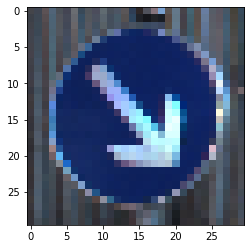

In [10]:
N = 50
n = 0
while True:
    n = np.random.randint(0,len(y_train))
    n= 4137
    X = X_train[n].reshape(1,*X_train[n].shape).astype(float)

    #### GET CORRECTLY CLASSIFIED INPUT 
    y_hat = np.argmax(bayes_model.predict(X,n=N))
    if y_train[n] == y_hat:
        break
    

plt.imshow(X_train[n],vmin=0,vmax=1)
print('Prediction:',y_hat)
print('n:',n)

In [11]:
if not os.path.exists(f'exps/exp{n}/'):
    os.mkdir(f'exps/exp{n}')

input_path = f'exps/exp{n}/X.npy'
y_path = f'exps/exp{n}/y.npy'
np.save(y_path,y_hat,False)
np.save(input_path,X,False)

iterations = 50
for i in range(iterations):
    subprocess.Popen(['python3','get_ig_exp.py',str(i),model_name,input_path,f'exps/exp{n}',str(43)])
        
full = False 
while not full:
    if len([name for name in os.listdir(f'exps/exp{n}') if os.path.isfile(os.path.join(f'exps/exp{n}', name))]) == iterations+2:
        full = True

In [15]:
print(max(y_train))

42


In [30]:
ns = [4137]
ns_exps = []
for n in ns:
    all_exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            if tmp.shape == (43,30,30,3):
                right_class = tmp[y_train[n]][:,:,0]
                #print(np.min(right_class),np.max(right_class))
                all_exps.append(tmp[y_train[n]][:,:,0])

    coverage_map = dict()
    max_rel = np.max(all_exps)
    limit = 0.02*max_rel
    for exp in all_exps:
        exp[exp < limit] = 0
        exp[exp > 0] = 1
        #plt.imshow(exp)
        #plt.show()
    ns_exps.append(all_exps)
#

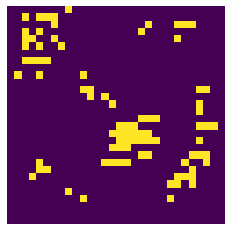

1 2.0


In [31]:
for exps in ns_exps:
    cmap = dict()
    names = []
    es = []
    for e in exps:
        if not str(e) in names:
            names.append(str(e))
            es.append(e)
            cmap[names.index(str(e))] = 0
        cmap[names.index(str(e))] += 1

    res = max(cmap,key=cmap.get)
    res_image = es[res]
    plt.imshow(res_image)
    plt.axis('off')
    plt.show()
    cov = (cmap[res]/50)*100

    print(cmap[res],cov)

In [32]:
from memo import memo

@memo
def generate_min_exps(expl,threshold):
    exps = []
    for i in range(len(expl)):
        orig_expl = expl
        if orig_expl[i] == 0:
            continue
        else:
            if i == len(expl) - 1:
                s = sum(orig_expl[:i])
            else:
                s = sum(orig_expl[:i])+sum(orig_expl[i+1:])
            if s < threshold:
                exps.append(expl)
                break
            else:
                new_expl = tuple(orig_expl[:i]) + (0,)
                if i < len(expl)-1:
                    new_expl = new_expl + tuple(orig_expl[i+1:])
                new_exps = generate_min_exps(new_expl,threshold)
                exps += new_exps
    return exps


In [46]:
import ast
ns = [4137]
exps = dict()
ns_exps = []
for n in ns:
    all_exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            if tmp.shape == (43,30,30,3):
                right_class = tmp[y_train[n]][:,:,0]
                #print(np.min(right_class),np.max(right_class))
                all_exps.append(tmp[y_train[n]][:,:,0])
            
    net_count = len(all_exps)
    #print(net_count)
    coverage_map = dict()
    max_rel = np.max(all_exps)
    limit = 0.03*max_rel
    all_new_exps = []
    for exp in all_exps[:5]:
        print(exp.shape)
        exp[exp < limit] = 0
        exp[exp > 0] = 1
        exp_list = list(set(generate_min_exps(tuple(exp.flatten()),0.98*np.sum(exp))))
        all_new_exps += exp_list
    ns_exps.append(all_new_exps)

(30, 30)
(30, 30)
(30, 30)
(30, 30)
(30, 30)


5079


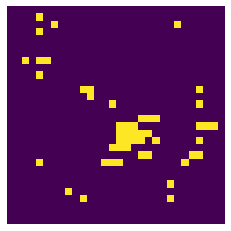

1 2.0


In [47]:
for exps in ns_exps:
    cmap = dict()
    pic_map = dict()
    print(len(exps))
    for e in exps:
        e = np.array(e)
        if not str(e) in cmap.keys():
            cmap[str(e)] = 0
            pic_map[str(e)] = np.array(e).reshape(30,30)
        #else:
        #    print('dupe')
        cmap[str(e)] += 1

    res = max(cmap,key=cmap.get)
    res_image = pic_map[res]
    plt.imshow(res_image)
    plt.axis('off')
    plt.show()
    cov = (cmap[res]/50)*100

    print(cmap[res],cov)

Prediction: 10


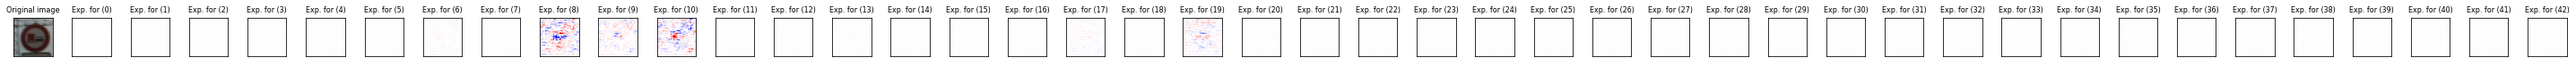

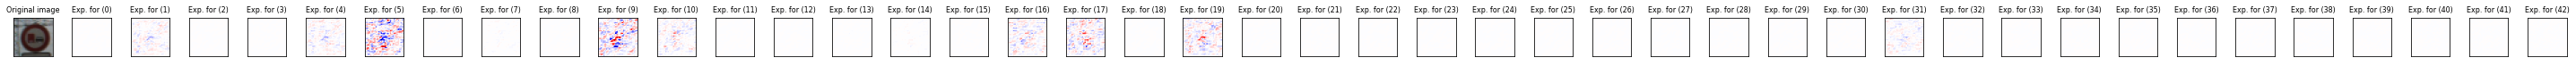

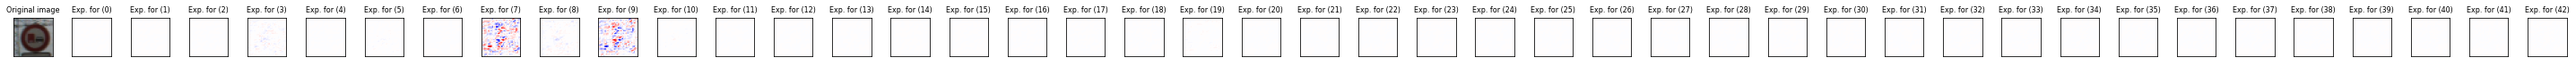

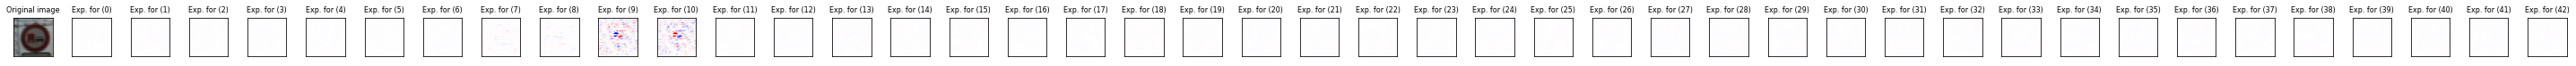

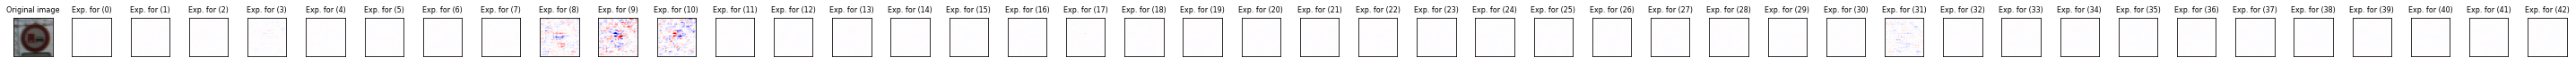

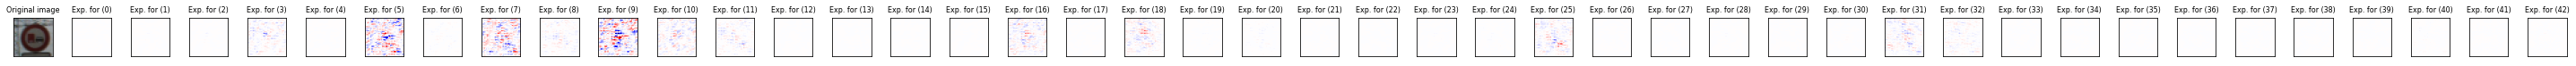

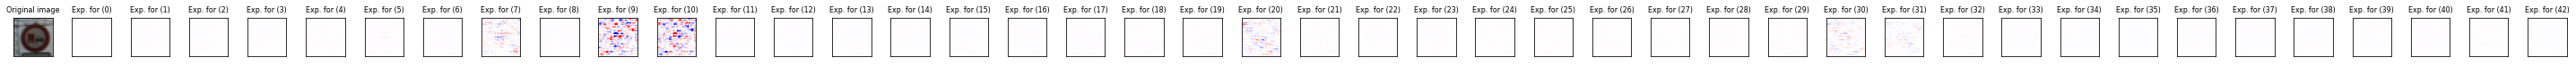

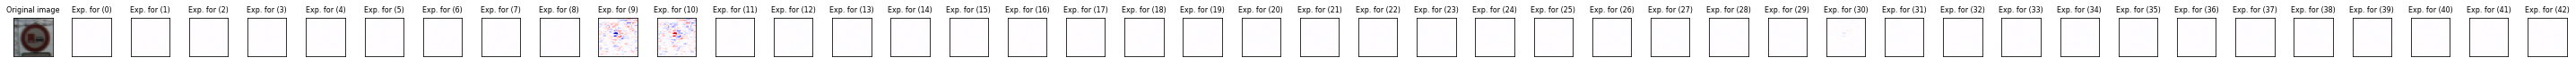

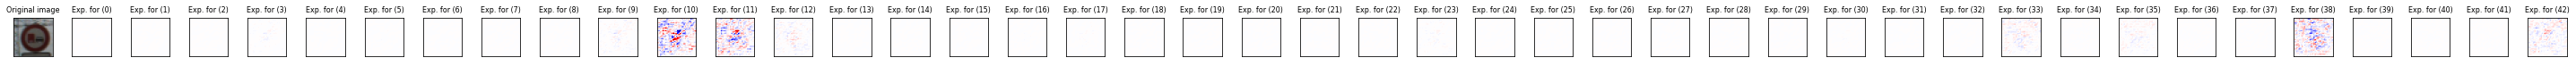

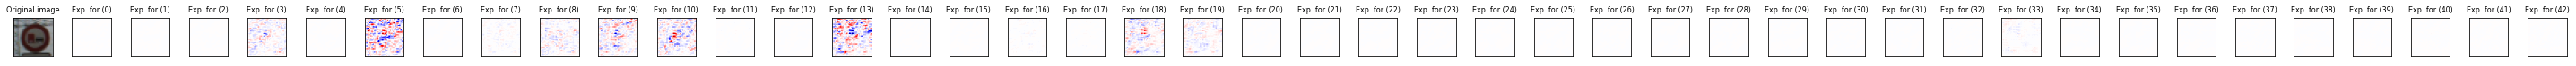

Prediction: 25


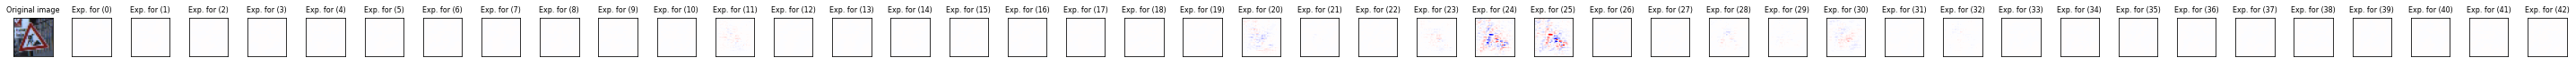

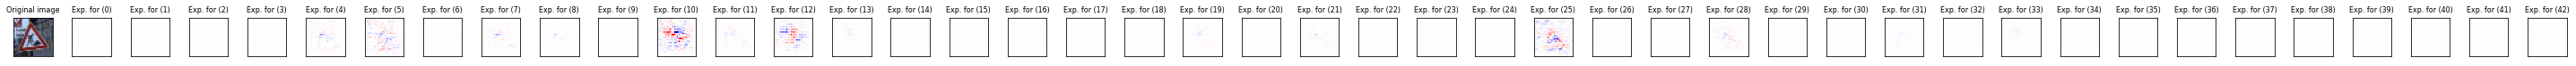

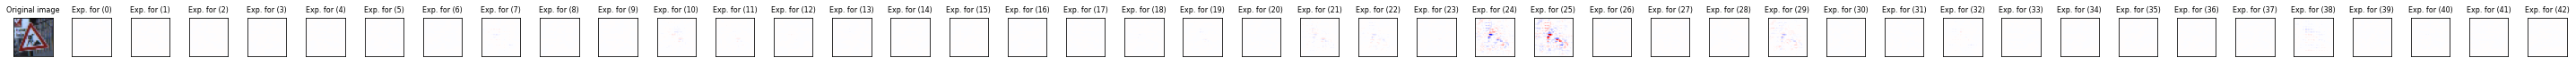

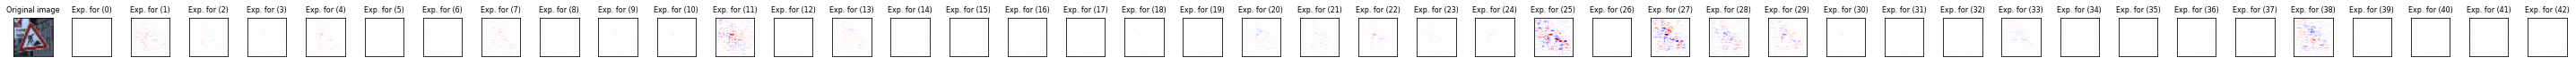

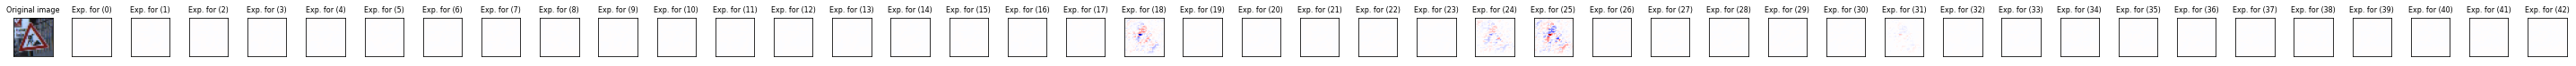

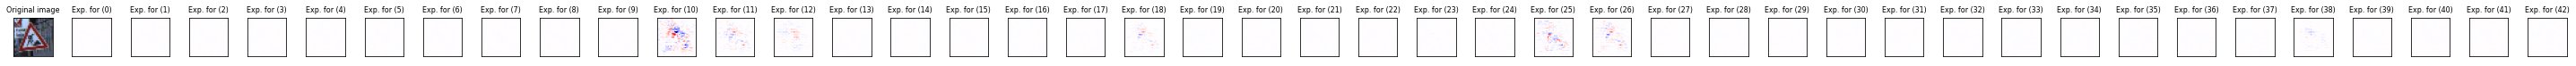

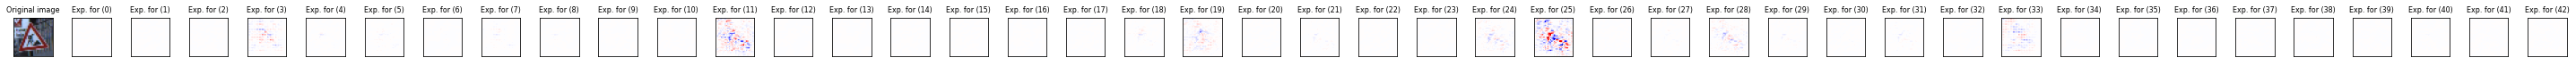

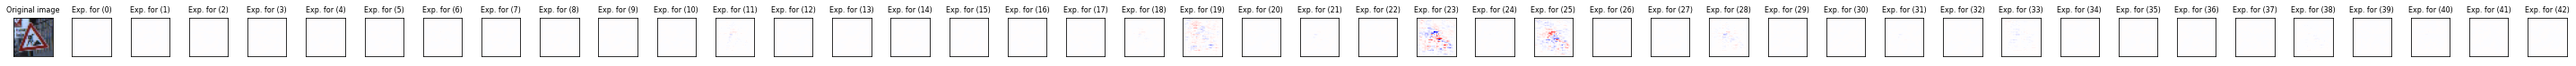

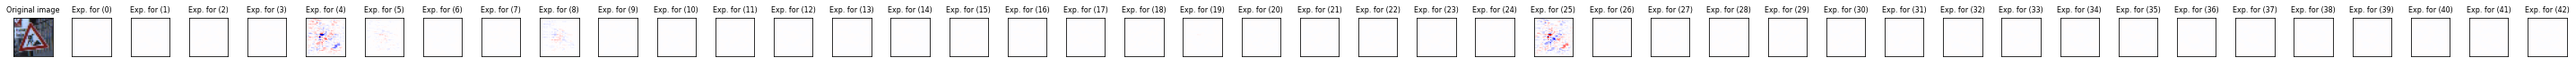

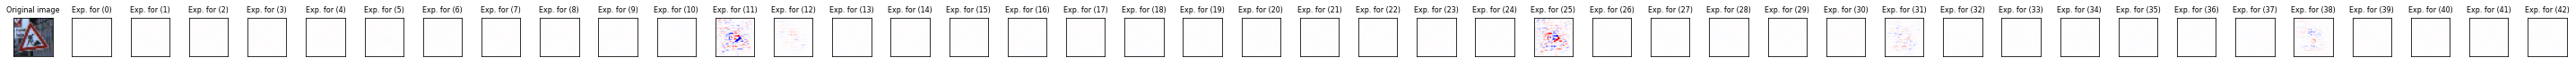

Prediction: 21


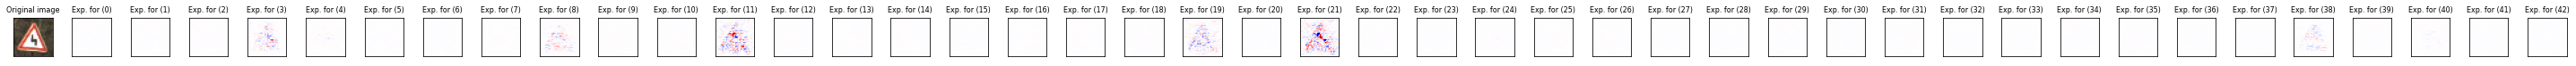

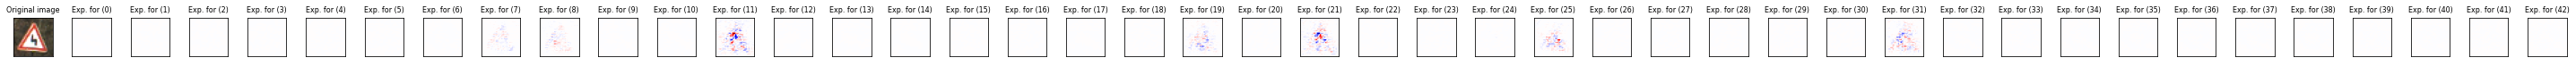

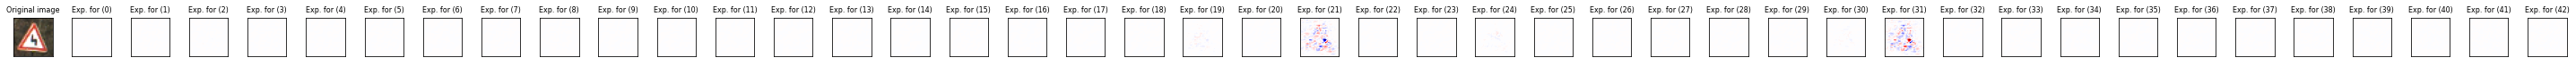

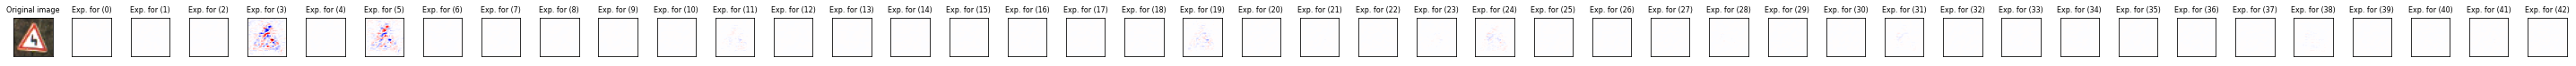

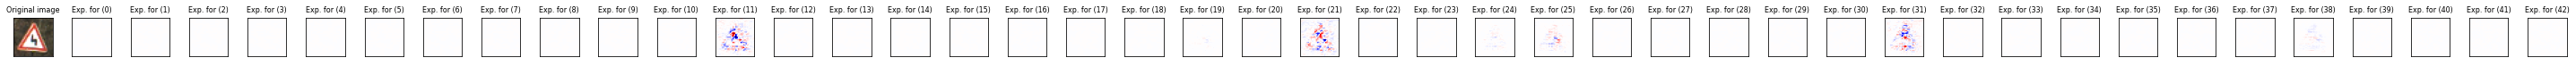

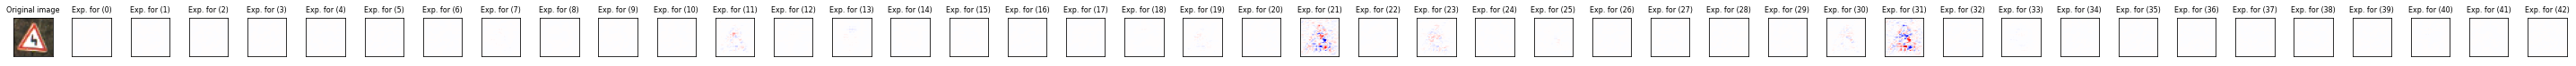

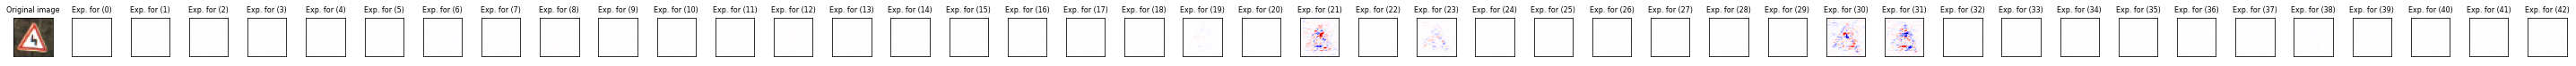

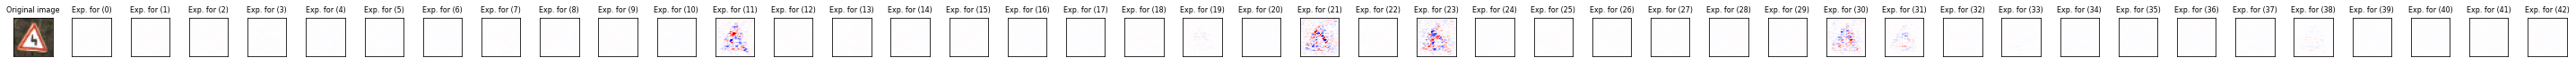

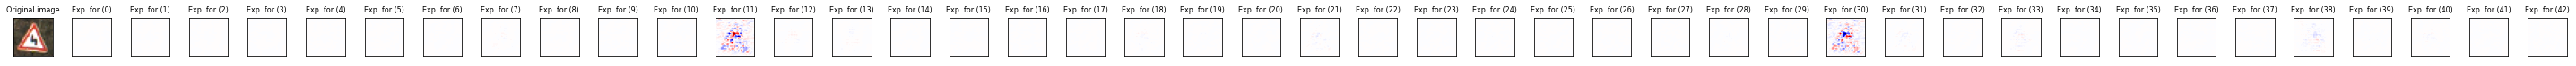

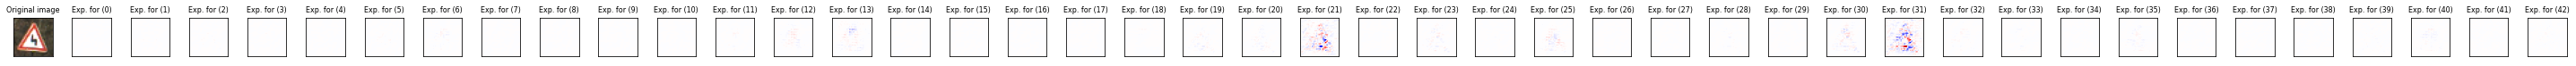

Prediction: 5


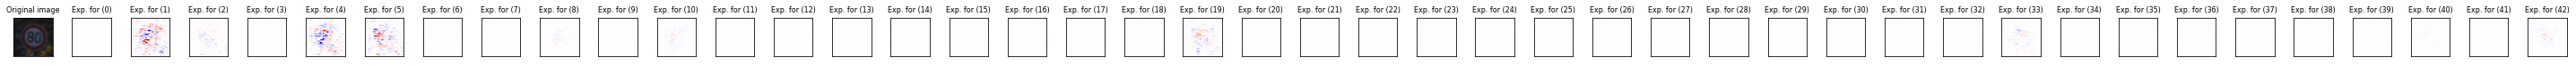

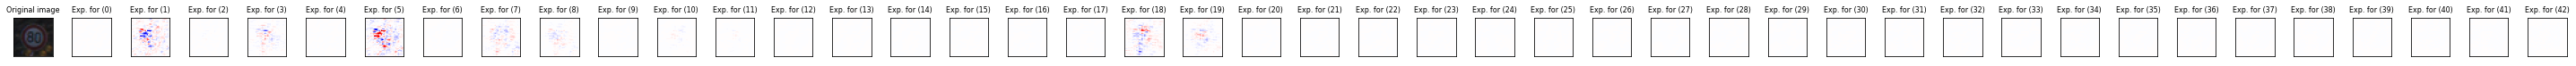

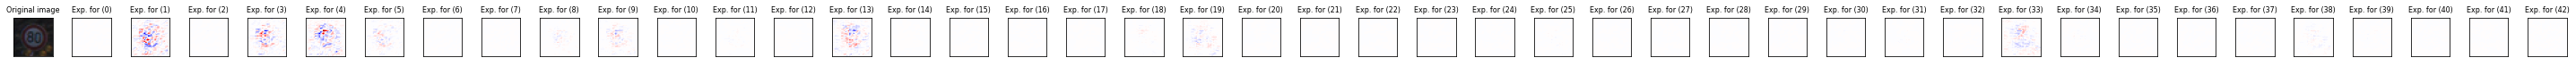

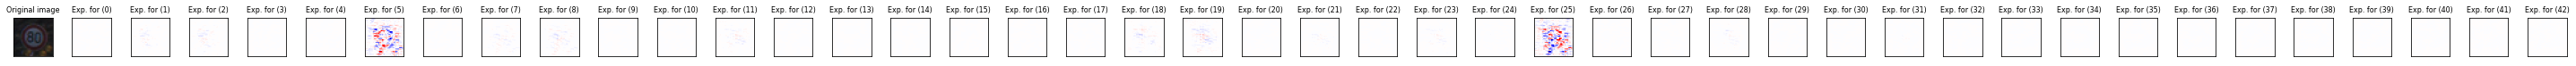

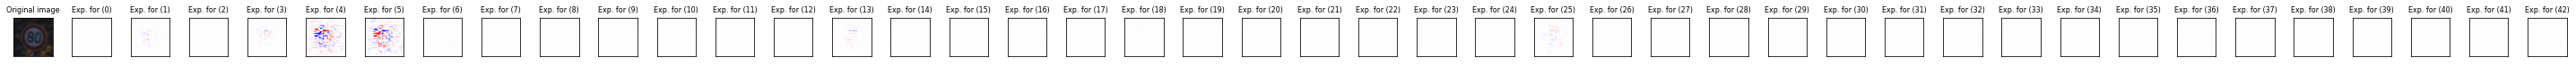

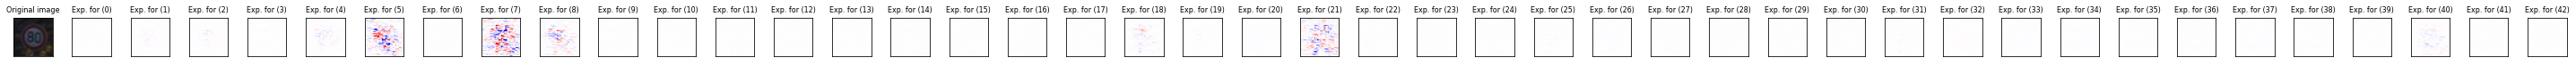

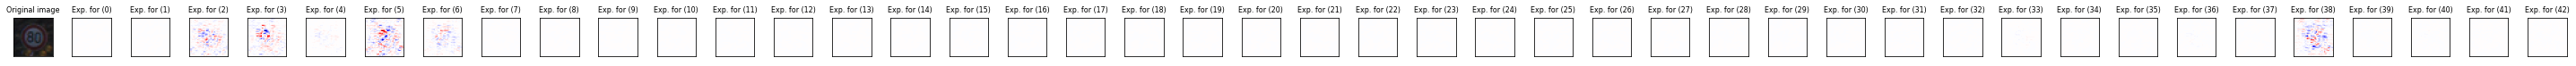

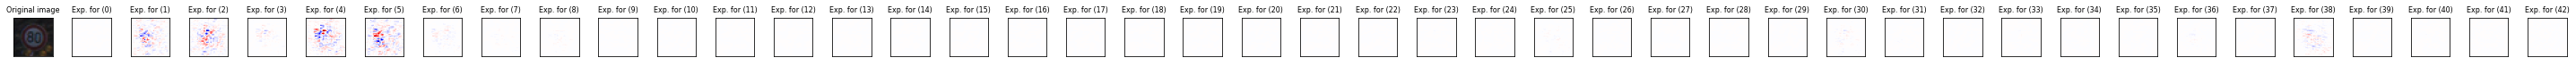

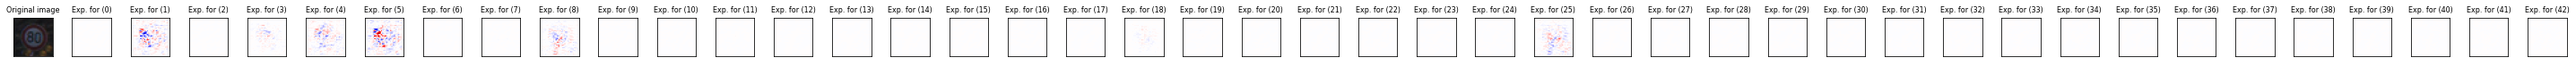

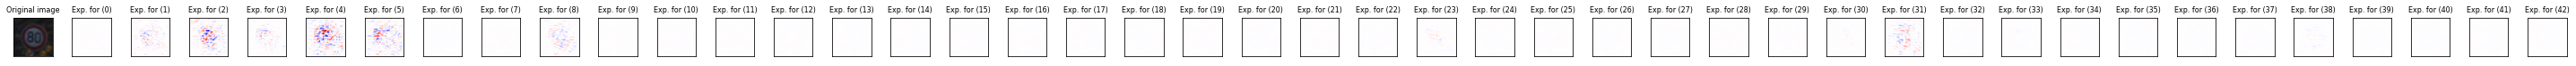

Prediction: 1


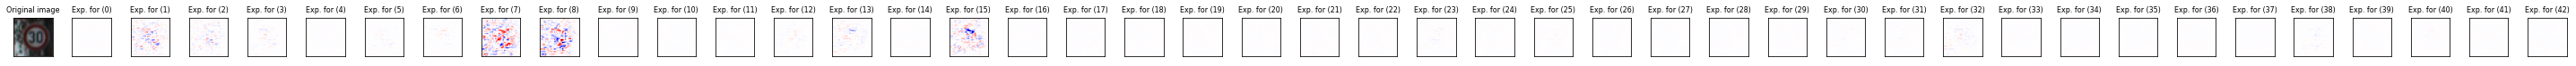

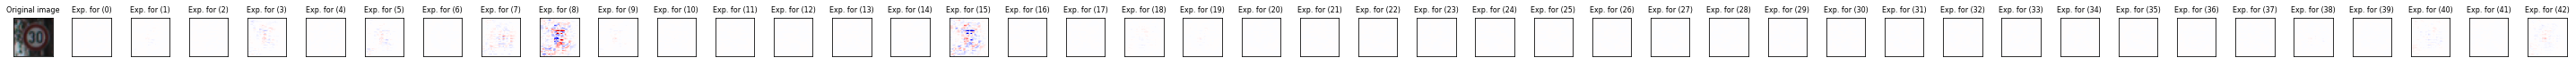

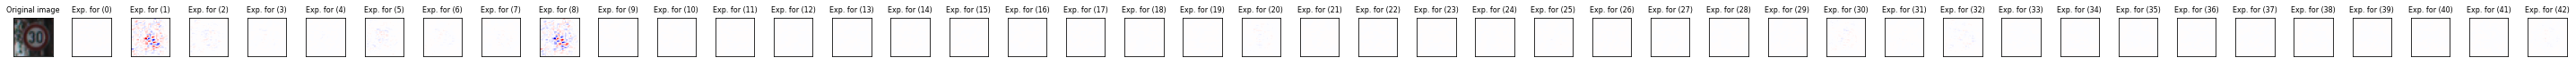

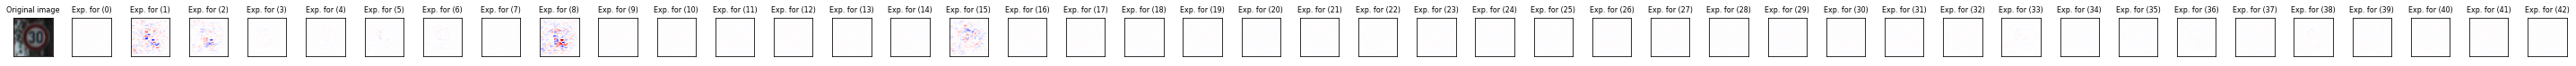

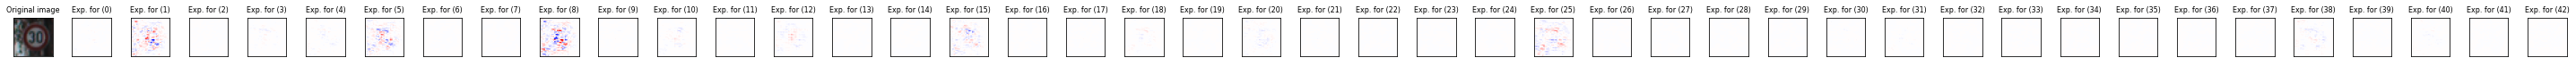

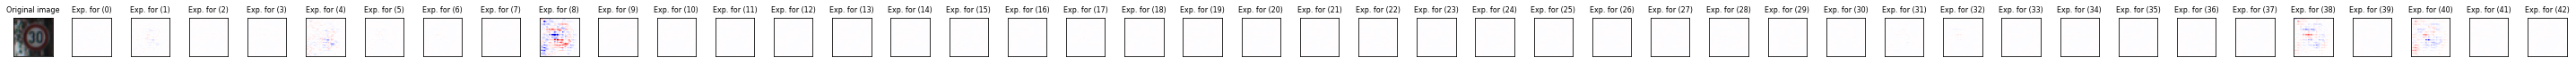

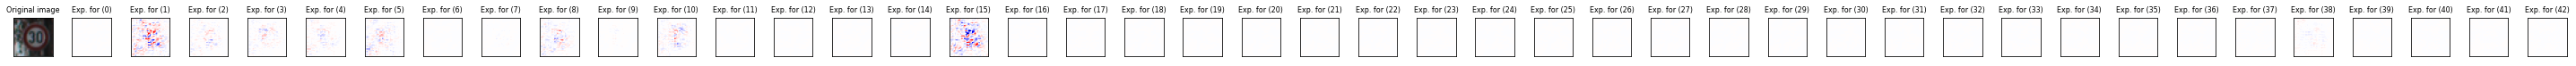

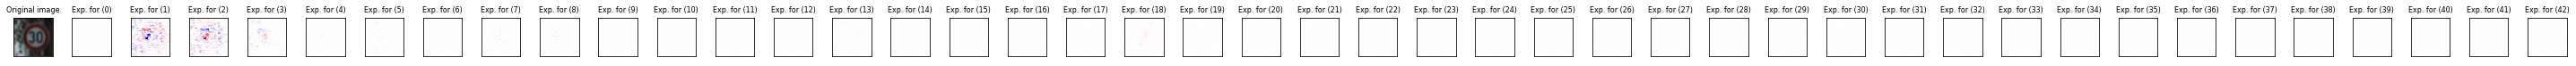

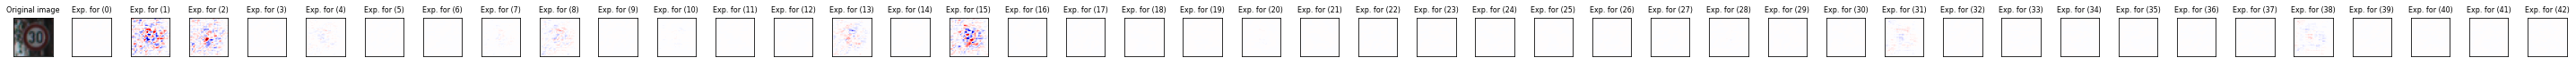

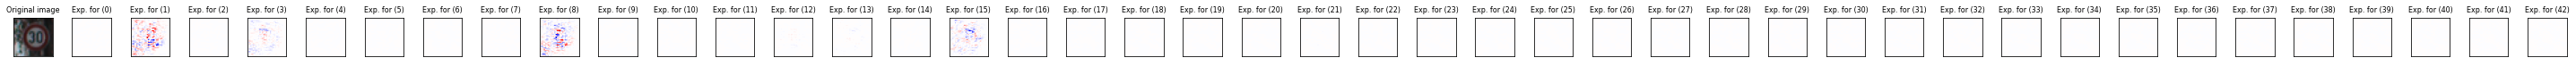

In [62]:
# read in and display the results from the above
ns = [9361,14992,3635,22590,21412]

exps_per_ns = dict()
for n in ns:
    exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            exps.append(tmp)

    X = np.load(f'exps/exp{n}/X.npy')
    y_hat = np.load(f'exps/exp{n}/y.npy')
    print('Prediction:',y_hat)
    for exs in exps:
        plt.figure(figsize=(40,1))
        plt.subplot(1,44,1)
        plt.imshow(X.reshape(30,30,3), cmap="Greys")
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title("Original image", fontsize=8)
        th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
        for i in range(1,44):
            ex = exs[i-1]
            plt.subplot(1,44,1+i)
            plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
            plt.xticks([],[])
            plt.yticks([],[])
            plt.title("Exp. for ("+str(i-1)+")", fontsize=8)
        plt.tight_layout()
        plt.show()
    exps_per_ns[n] = exps.copy()
    print('==============================================')

Prediction: 10


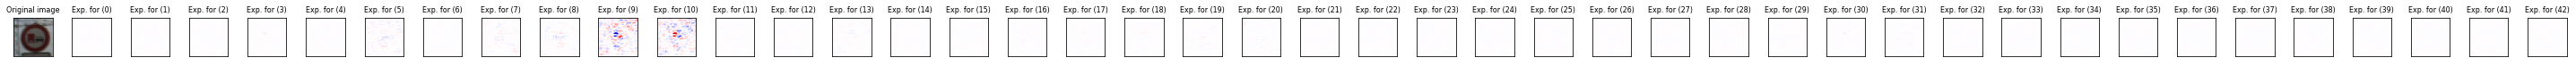

Prediction: 25


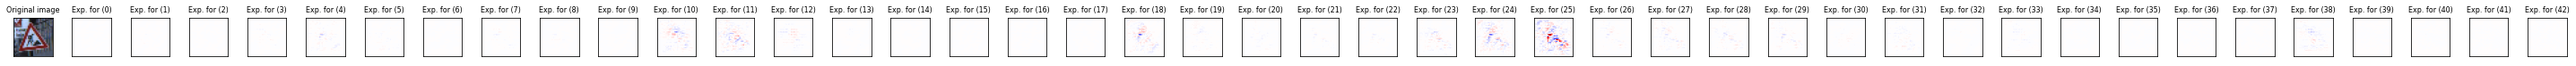

Prediction: 21


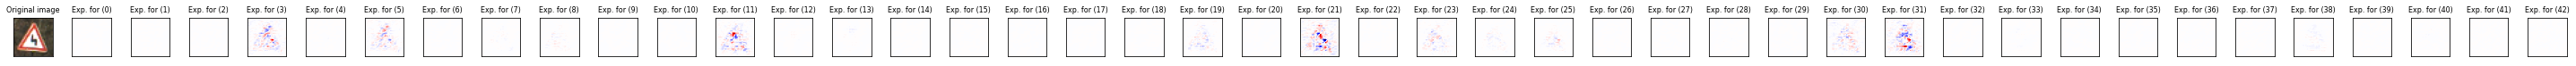

Prediction: 5


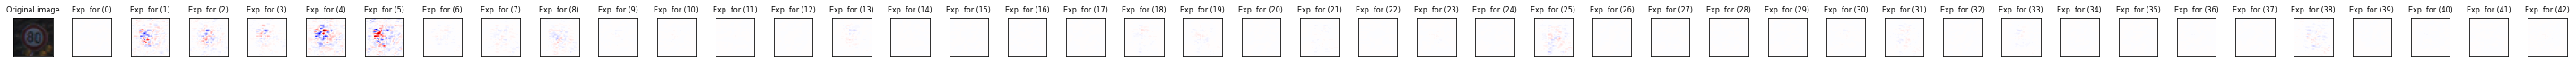

Prediction: 1


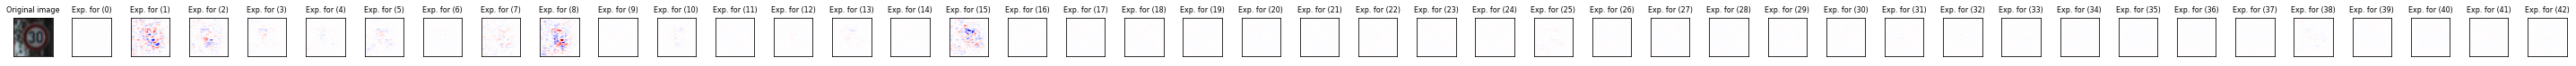

In [57]:
for n in ns:
    exps = exps_per_ns[n]
    np_exps = np.array(exps)
    
    X = np.load(f'exps/exp{n}/X.npy')
    y_hat = np.load(f'exps/exp{n}/y.npy')
    print('Prediction:',y_hat)
    # (explanation #i, digit n, imagex, imagey, imagez)
    exs_new = []
    for i in range(43):
        exs_new.append(np.sum(np_exps[:,i,:,:],axis=0)/len(np_exps[:,i,:,:]))
        
    exs = np.array(exs_new)
    plt.figure(figsize=(40,1))
    plt.subplot(1,44,1)
    plt.imshow(X.reshape(30,30,3), cmap="Greys")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("Original image", fontsize=8)
    th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
    for i in range(1,44):
        ex = exs[i-1]
        #print(ex)
        plt.subplot(1,44,1+i)
        plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title("Exp. for ("+str(i-1)+")", fontsize=8)
    plt.tight_layout()
    plt.show()
    print('====================================================')

## Uncertain (but correctly classified just about) examples

35
[35, 36, 35, 35, 15, 21, 37, 35, 15, 24, 35, 35, 35, 35, 35, 15, 37, 29, 32, 35, 32, 15, 30, 35, 21, 9, 13, 35, 32, 15, 37, 13, 35, 36, 37, 41, 2, 21, 35, 29, 3, 21, 11, 21, 18, 38, 15, 15, 11, 39]
Prediction: 35
n: 3441


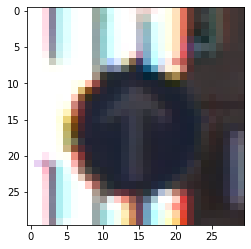

In [77]:
N = 50
n = 0
while True:
    n = np.random.randint(0,len(y_train))
    X = X_train[n].reshape(1,*X_train[n].shape).astype(float)
    

    bayes_model.set_weights(bayes_model.sample())
    prediction = [np.array(bayes_model._predict(X))[0]]
    for i in range(N-1):
        bayes_model.set_weights(bayes_model.sample())
        prediction.append(np.array(bayes_model._predict(X))[0])
    y_hat_ls = list(np.argmax(prediction,axis=1))
    y_hat = mode(y_hat_ls)
    if y_hat_ls.count(y_hat) < 0.6*50 and y_train[n] == y_hat:
        print(y_hat)
        print(y_hat_ls)
        break
    

plt.imshow(X_train[n],vmin=0,vmax=1)
print('Prediction:',y_hat)
print('n:',n)

In [78]:
if not os.path.exists(f'exps/exp{n}/'):
    os.mkdir(f'exps/exp{n}')

input_path = f'exps/exp{n}/X.npy'
y_path = f'exps/exp{n}/y.npy'
np.save(y_path,y_hat,False)
np.save(input_path,X,False)

iterations = 10
for i in range(iterations):
    subprocess.Popen(['python3','get_ig_exp.py',str(i),model_name,input_path,f'exps/exp{n}',str(43)])
        
full = False 
while not full:
    if len([name for name in os.listdir(f'exps/exp{n}') if os.path.isfile(os.path.join(f'exps/exp{n}', name))]) == iterations+2:
        full = True

Prediction: 26


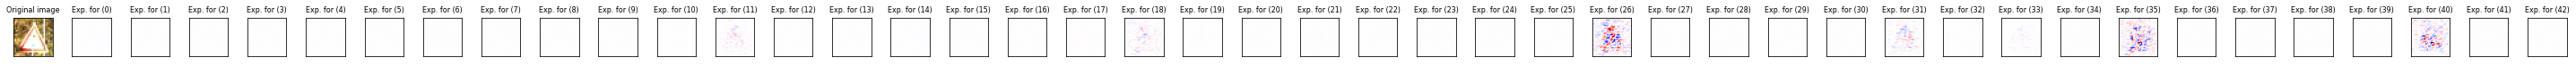

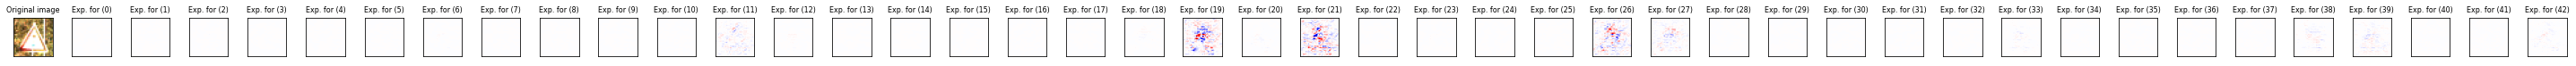

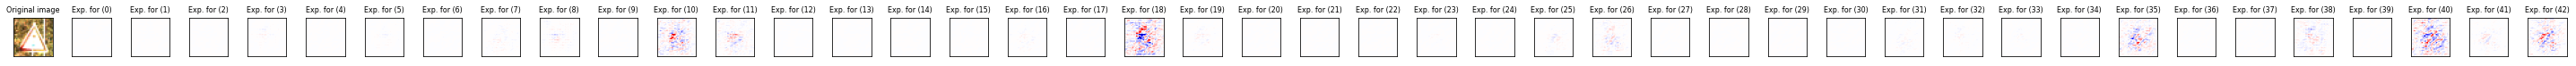

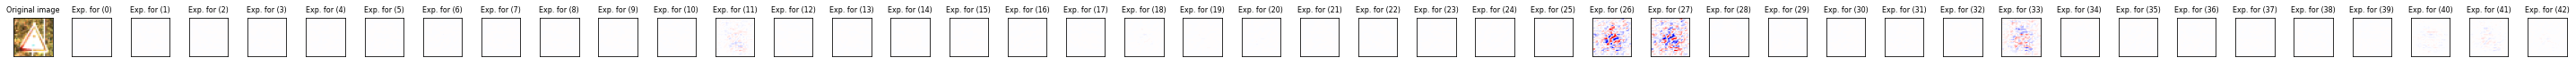

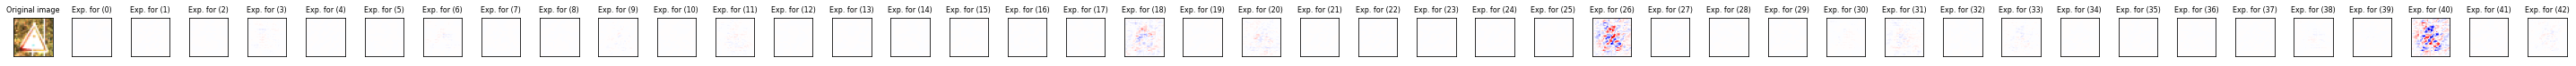

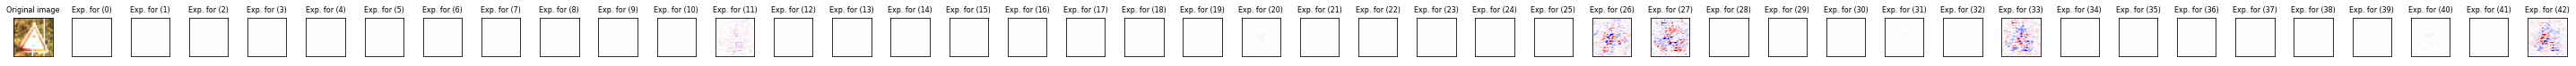

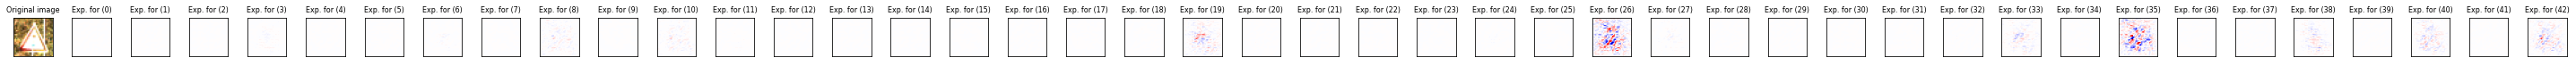

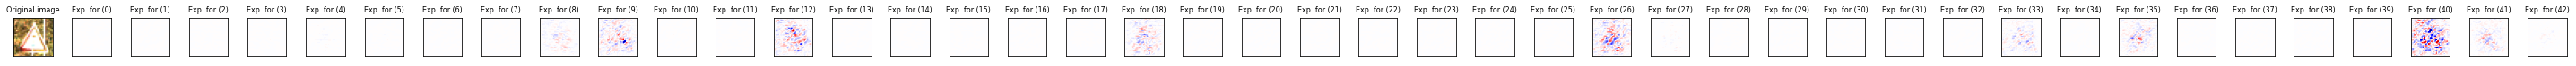

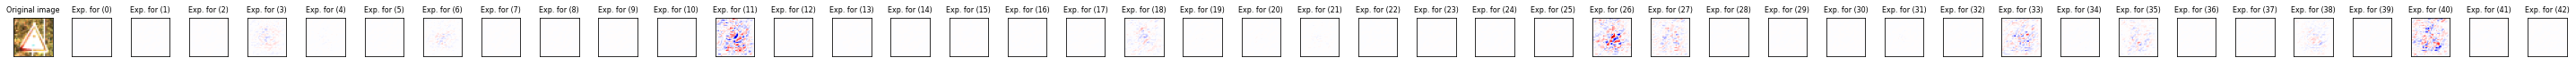

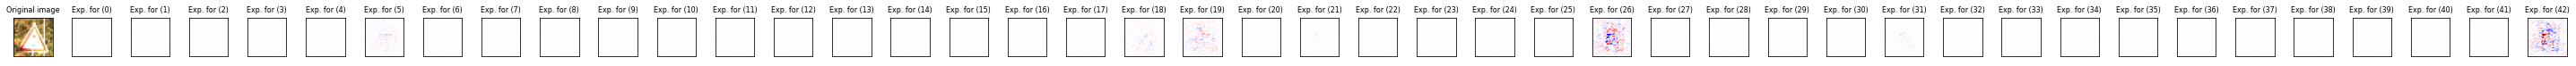

Prediction: 1


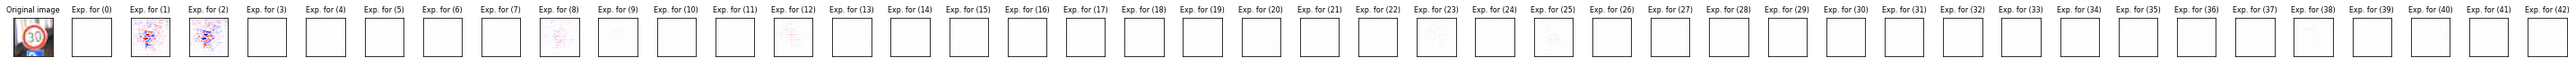

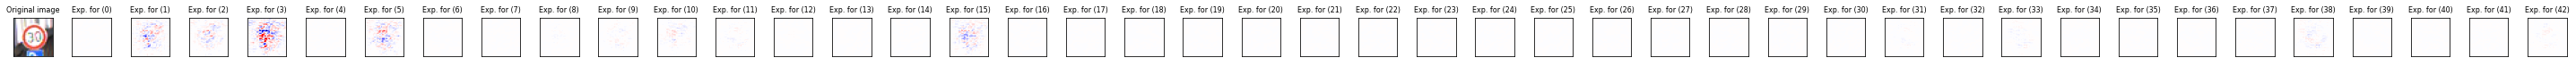

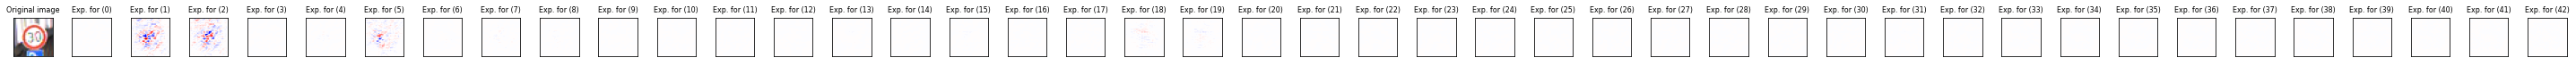

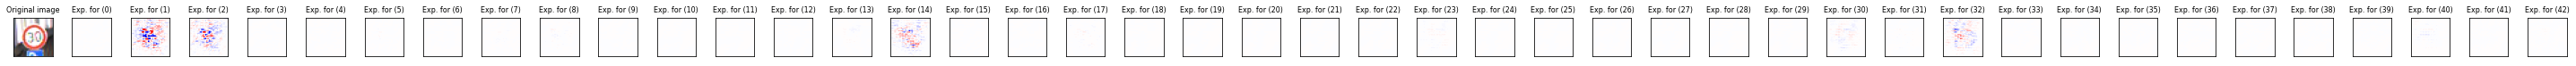

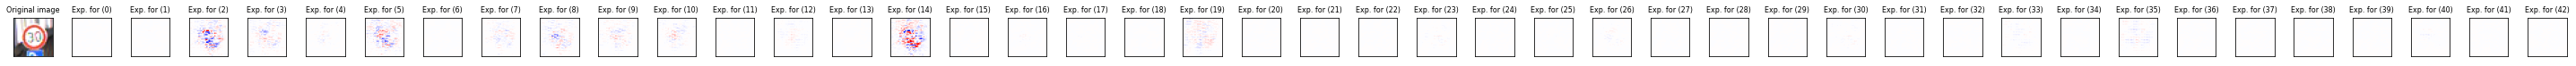

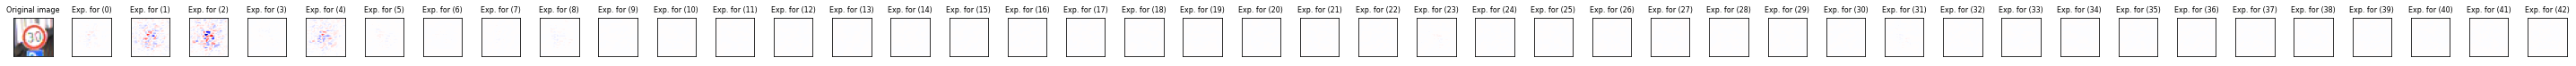

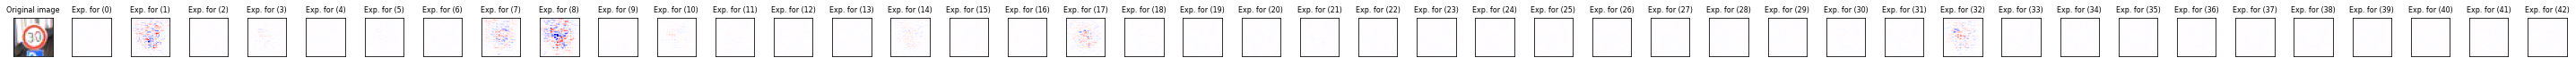

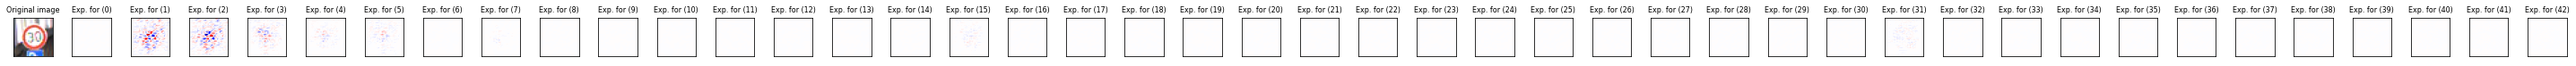

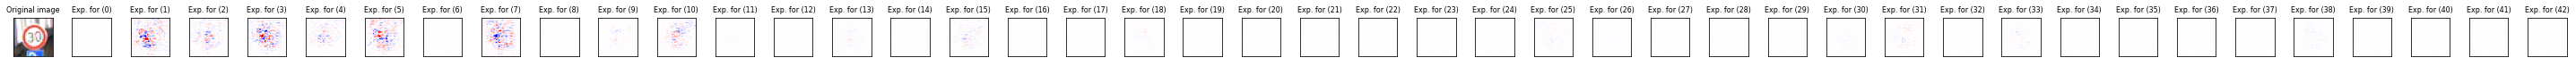

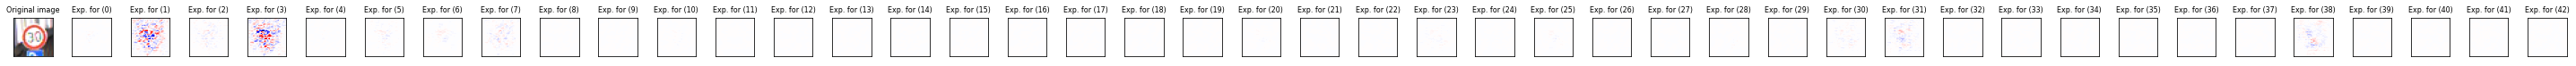

Prediction: 5


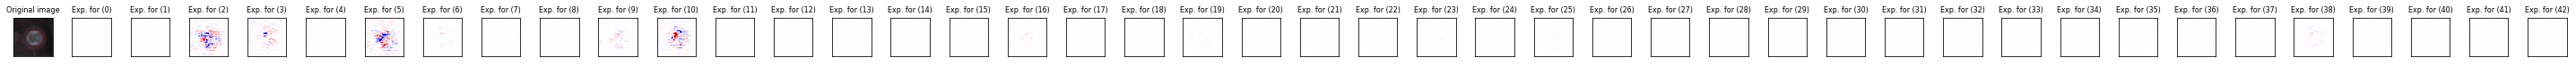

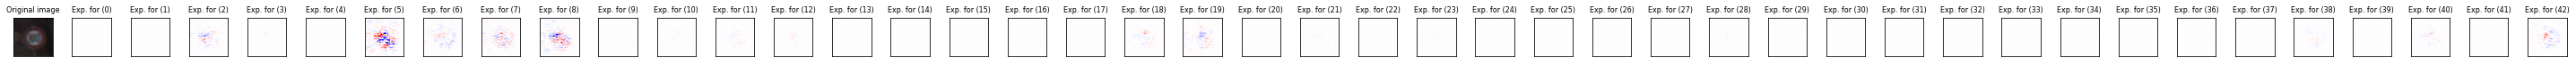

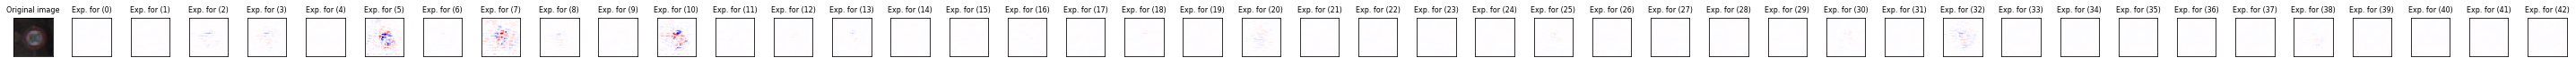

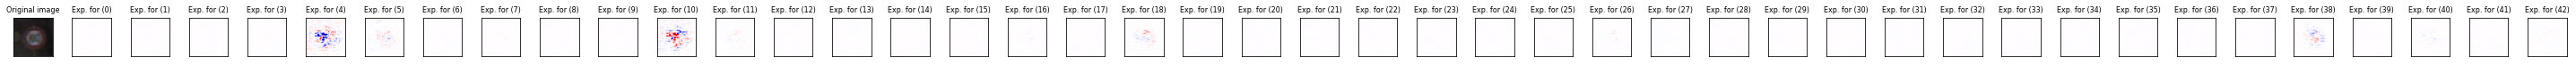

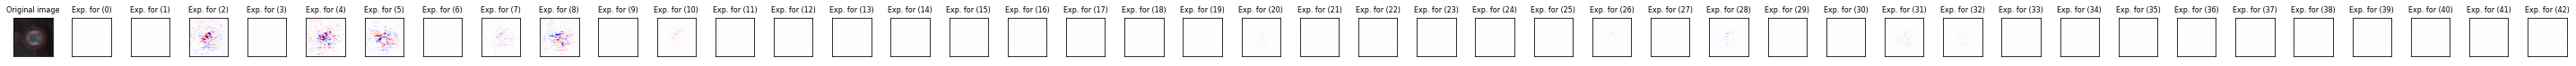

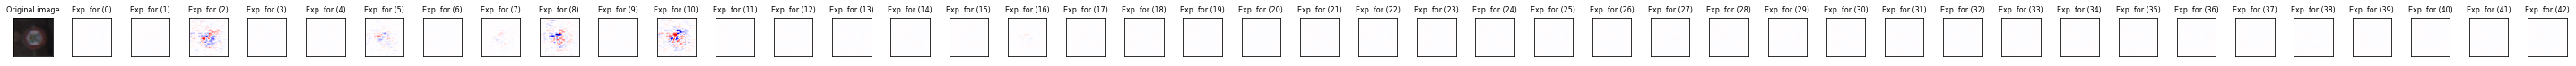

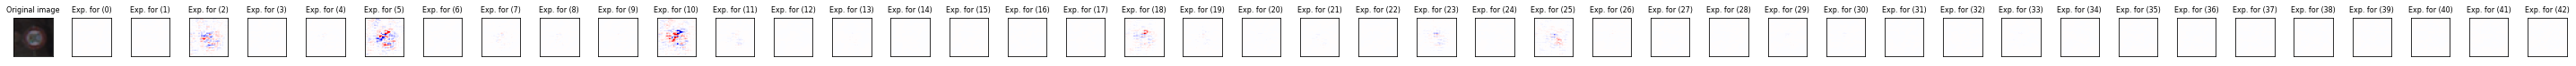

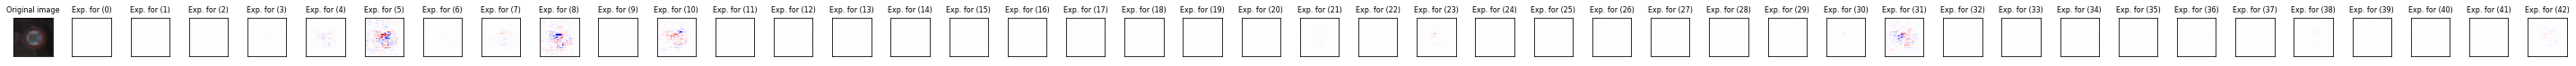

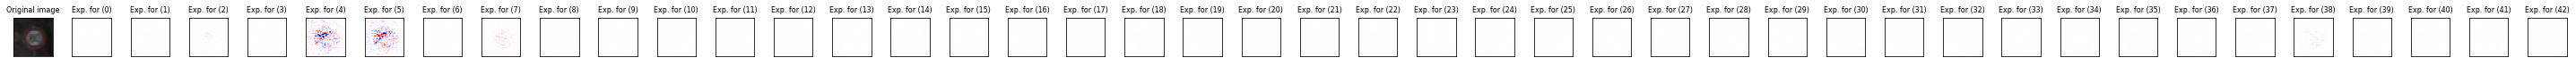

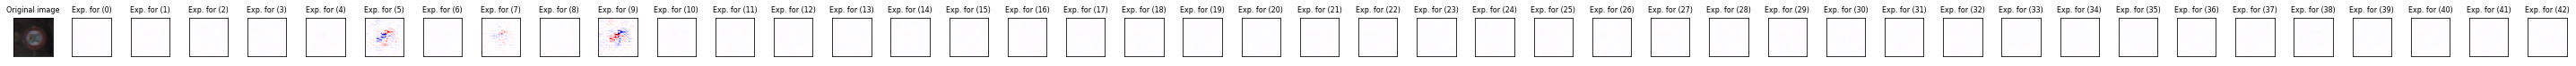

Prediction: 17


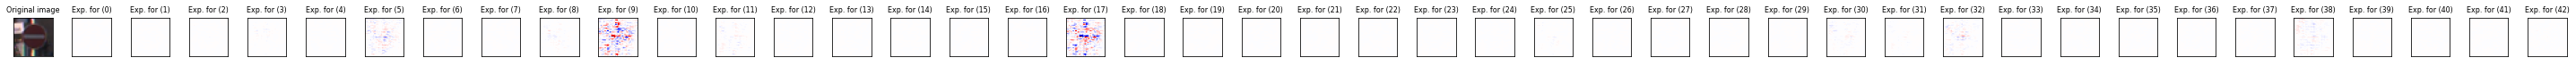

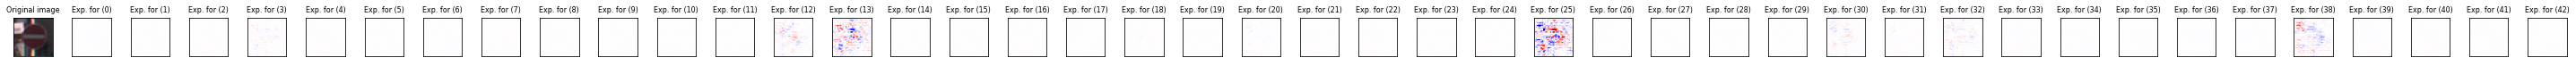

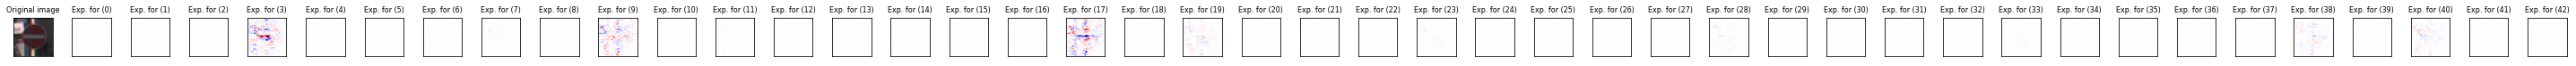

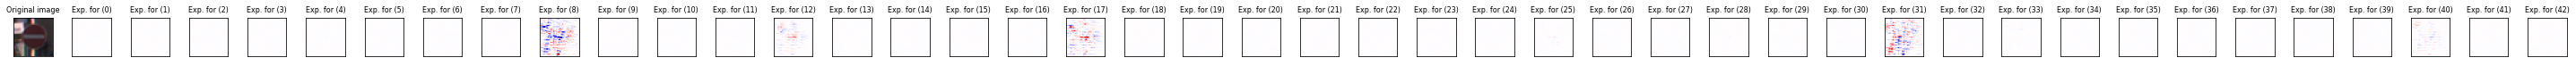

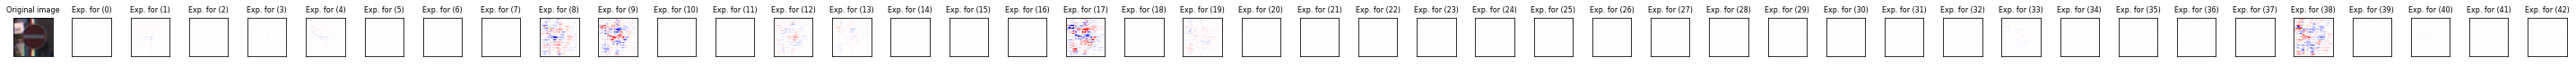

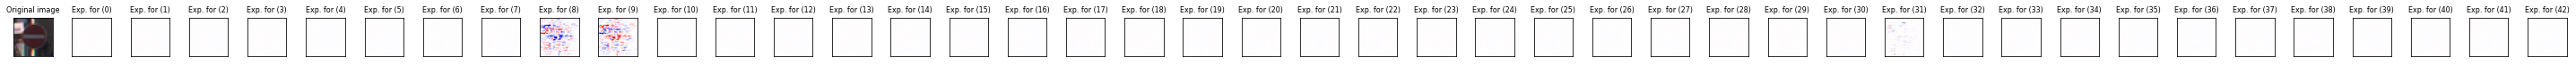

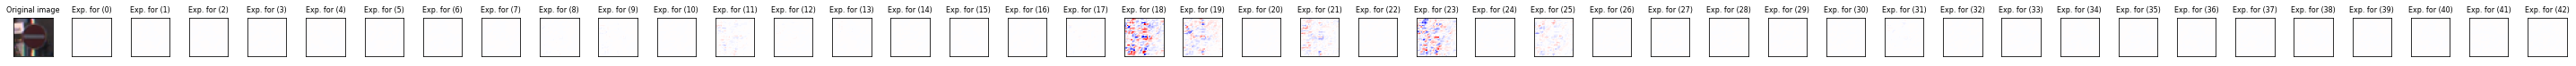

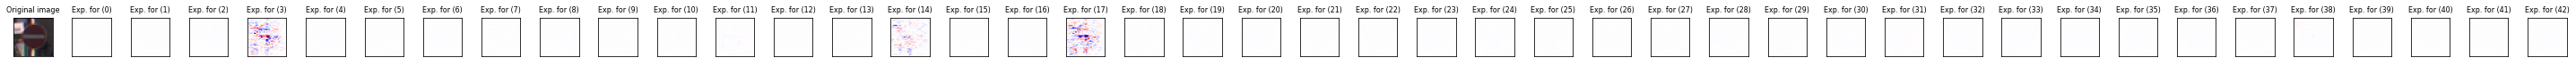

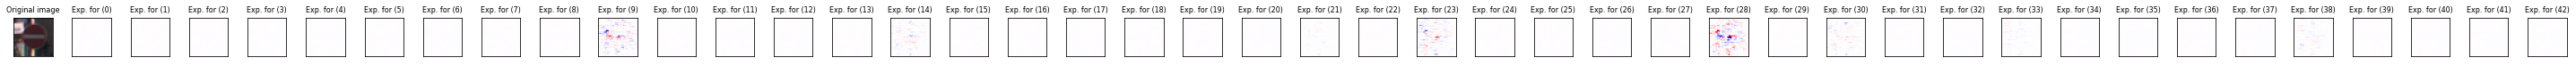

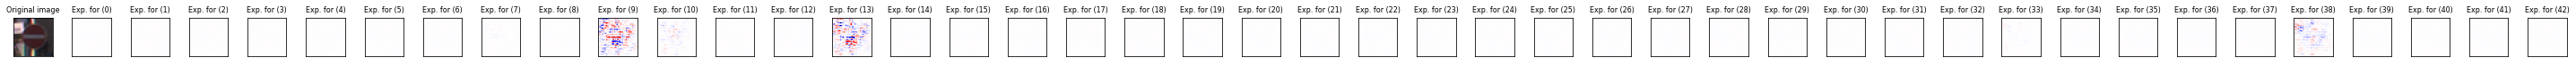

Prediction: 35


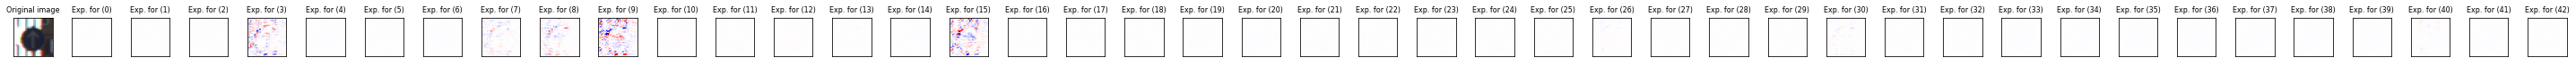

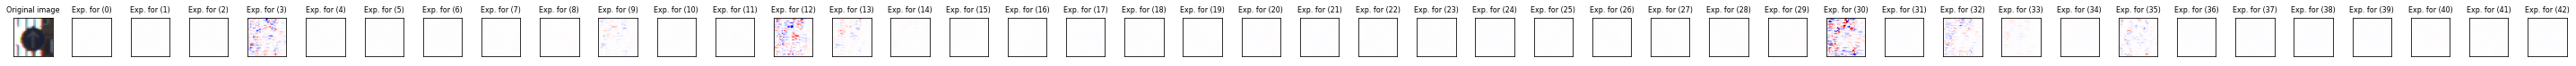

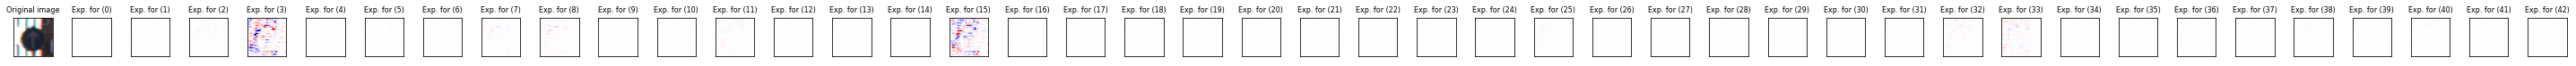

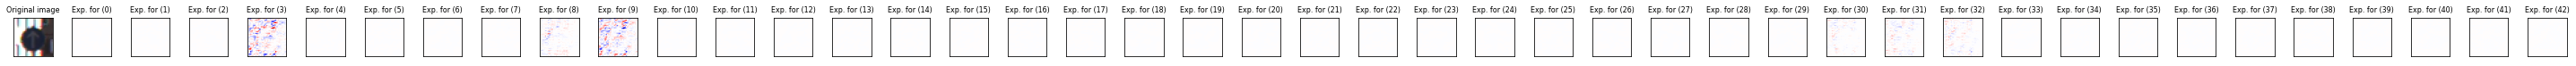

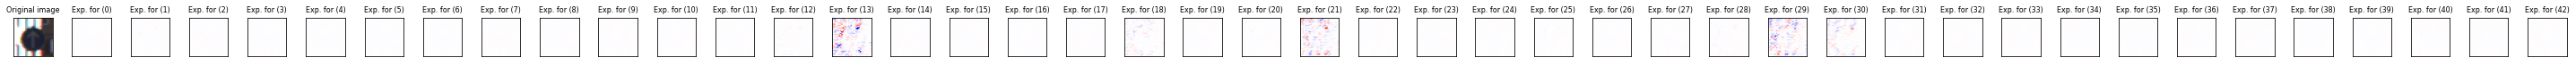

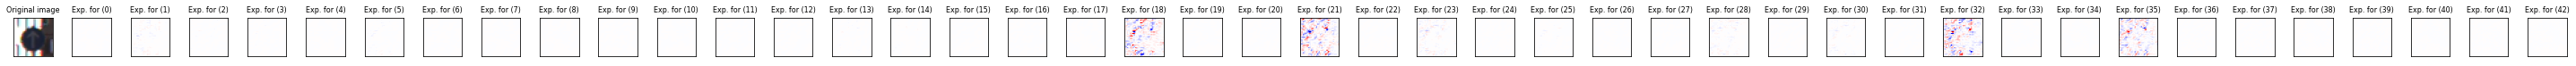

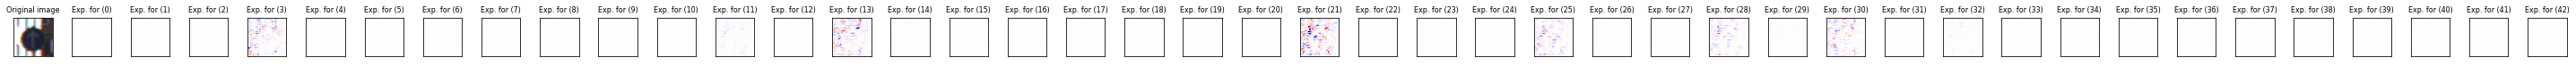

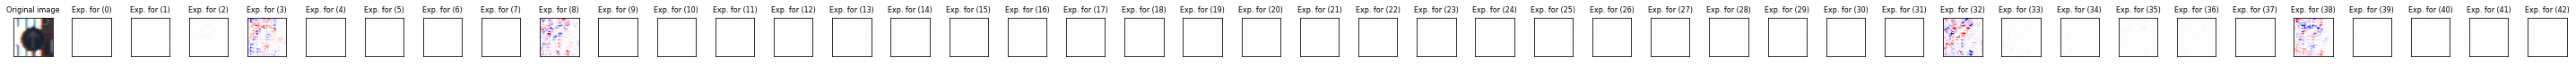

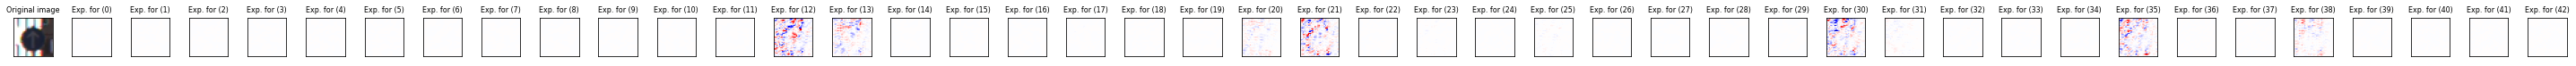

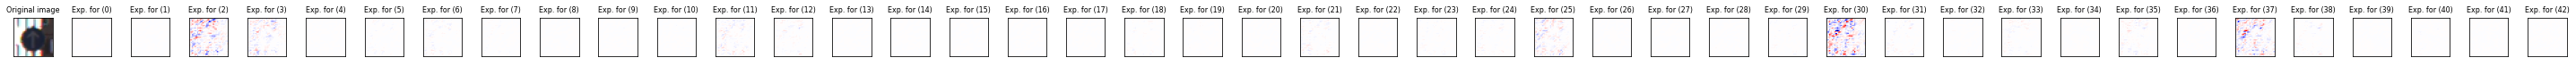

In [81]:
# read in and display the results from the above
ns = [18032,17617,30073,8272,3441]

exps_per_ns = dict()
for n in ns:
    exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            exps.append(tmp)

    X = np.load(f'exps/exp{n}/X.npy')
    y_hat = np.load(f'exps/exp{n}/y.npy')
    print('Prediction:',y_hat)
    for exs in exps:
        plt.figure(figsize=(40,1))
        plt.subplot(1,44,1)
        plt.imshow(X.reshape(30,30,3), cmap="Greys")
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title("Original image", fontsize=8)
        th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
        for i in range(1,44):
            ex = exs[i-1]
            plt.subplot(1,44,1+i)
            plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
            plt.xticks([],[])
            plt.yticks([],[])
            plt.title("Exp. for ("+str(i-1)+")", fontsize=8)
        plt.tight_layout()
        plt.show()
    exps_per_ns[n] = exps.copy()
    print('==============================================')

Prediction: 26


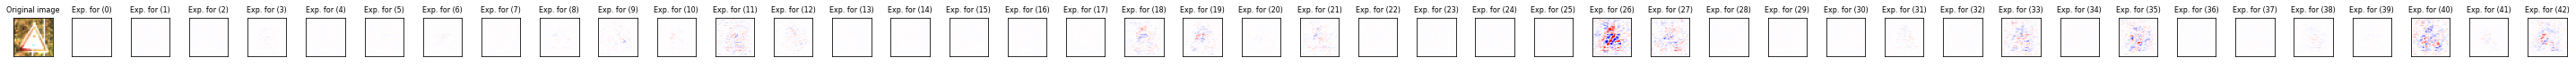

Prediction: 1


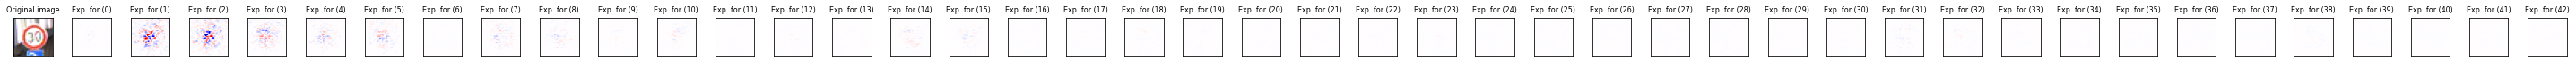

Prediction: 5


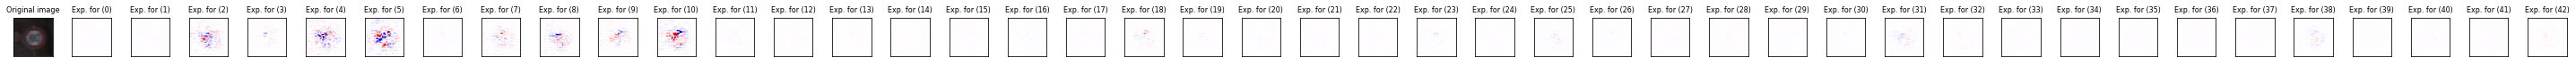

Prediction: 17


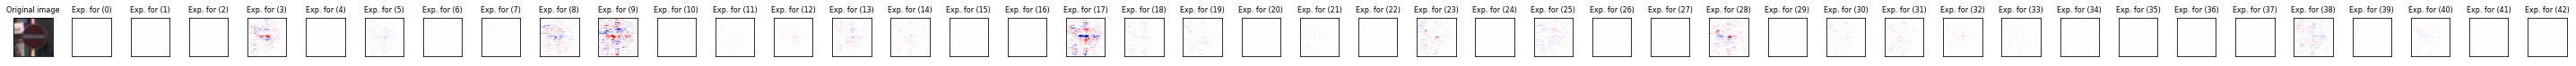

Prediction: 35


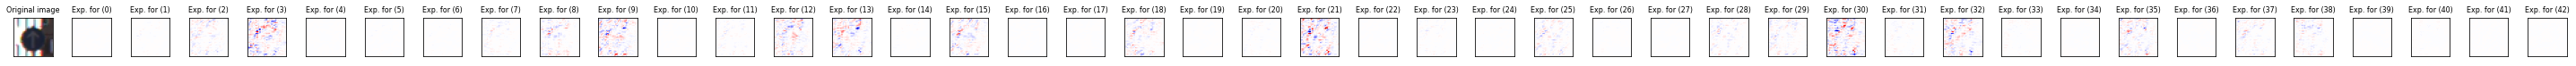

In [80]:
for n in ns:
    exps = exps_per_ns[n]
    np_exps = np.array(exps)
    
    X = np.load(f'exps/exp{n}/X.npy')
    y_hat = np.load(f'exps/exp{n}/y.npy')
    print('Prediction:',y_hat)
    # (explanation #i, digit n, imagex, imagey, imagez)
    exs_new = []
    for i in range(43):
        exs_new.append(np.sum(np_exps[:,i,:,:],axis=0)/len(np_exps[:,i,:,:]))
        
    exs = np.array(exs_new)
    plt.figure(figsize=(40,1))
    plt.subplot(1,44,1)
    plt.imshow(X.reshape(30,30,3), cmap="Greys")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("Original image", fontsize=8)
    th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
    for i in range(1,44):
        ex = exs[i-1]
        #print(ex)
        plt.subplot(1,44,1+i)
        plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title("Exp. for ("+str(i-1)+")", fontsize=8)
    plt.tight_layout()
    plt.show()
    print('====================================================')